In [1]:
import torch
import numpy as np
import sklearn

from utils import *
from architectures import *
import preprocess

import matplotlib.pyplot as plt

from CategoricalDiffusion import *
from denoiser import *

In [12]:
N_samples = 100000

M = 2
N_dim = 100

bias = torch.zeros((N_dim,1))
patterns = 2*torch.bernoulli(torch.ones((N_dim, M)) * 0.5) - 1

spins = generate_data(patterns, bias, N_samples, beta=4)

100%|█████████████████████████████████████████| 100/100 [03:15<00:00,  1.96s/it]


In [9]:
torch.matmul(patterns.t(), patterns)

tensor([[100., -12.],
        [-12., 100.]])

(array([18746.,     0., 11419.,     0.,   725., 38948.,     0., 11452.,
            0., 18710.]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <BarContainer object of 10 artists>)

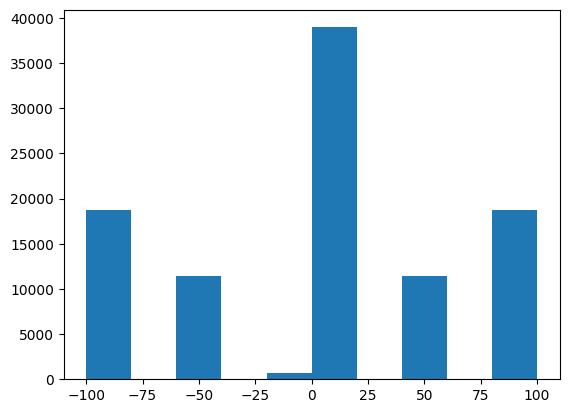

In [13]:
plt.hist(torch.matmul(spins, patterns)[:,0])